# Prueba T√©cnica ‚Äì DSS
### Vacante: Ingeniero en Inteligencia Artificial / Cient√≠fico de Datos
### Postulante: Marcelo Vidal Bravo

---
### Introducci√≥n

La prueba consta de tres ejercicios generales. El formato de entrega es un `jupyter notebook` con las actividades desarrolladas y una leve descripci√≥n de los pasos utilizados para resolver las preguntas.

## Ejercicio 1

El primero es un ejercicio de SQL, puede ser resuelto utilizando diferentes frameworks para manipular tablas, tales como: `SQL`, `pandas` , `polars`, incluso ciclos for en caso de ser necesario. Las preguntas de la actividad se detallan a continuaci√≥n:

A partir del archivo `datos.parquet` √≥ `datos.csv` determine los siguientes campos:
- Determine la cantidad total de informes validados enviados por cada `Fuente`.
- Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

- Determine el la `fecha` del √∫ltimo informe validado enviado anteriormente por la fuente.
- - Para esto considere que un informe es valido si es `Validado` o `Parcialmente Validado` y las caracteristicas del informe `Cumplen` con el estandar establecido.
- - De igual manera los informes deben respetar la `clasificacion` existente.
- - El resultado debe ser una columna adicional con el nombre `fecha_ultimo_muestreo_validado`, para los casos donde no exista un informe asociado rellene con `nulos`.

#### Descripci√≥n de la data
Una breve descripci√≥n de la data se presenta a continuaci√≥n:
- `fuente_id` : Representa el ID asociado a cada fuente, llave externa.
- `clasificacion` : Una clasificaci√≥n interna asociada a cada combustible. Una fuente puede tener m√°s de una clasificaci√≥n, esto representa que tiene m√°s de un componente asociado.
- `fecha_envio` : Fecha de env√≠o de los informes
- `estado_informe` : Estado del informe luego de ser recepcionado.
- `envio_id` : Llave externa asociada a los registros en el sistema, una misma `fuente` puede tener m√°s de un valor de `envio_id`.
- `caracteristicas_informe` : Columna que espec√≠fica si un informe cumple o no las condiciones para pasar a la siguiente etapa de an√°lisis.


# Ejercicio 1 ‚Äî KPI de informes validados y trazabilidad por fuente  

## Objetivo  
Construir indicadores confiables para monitorear el estado de los **informes** y su **trazabilidad** por **fuente**, respondiendo:  
1. ¬øCu√°ntos informes **v√°lidos** tiene cada fuente?  
2. ¬øQu√© fuente tiene **m√°s informes que ‚Äúcumplen‚Äù**?  
3. ¬øCu√°l fue la **√∫ltima fecha de muestreo validado** por fuente?

---

## Definiciones (alineadas a negocio)  
- **Informe v√°lido**: `estado_informe ‚àà {Validado, Validado parcialmente}` **y** `caracteristicas_informe` contiene ‚Äúcumple‚Äù (insensible a may√∫sculas).  
- **Cumple**: detecci√≥n textual de la palabra ‚Äúcumple‚Äù en `caracteristicas_informe` (insensible a may√∫sculas; tolera nulos).  

---

## Descripci√≥n de la data
Una breve descripci√≥n de la data se presenta a continuaci√≥n:
- `fuente_id` : Representa el ID asociado a cada fuente, llave externa.
- `clasificacion` : Una clasificaci√≥n interna asociada a cada combustible. Una fuente puede tener m√°s de una clasificaci√≥n, esto representa que tiene m√°s de un componente asociado.
- `fecha_envio` : Fecha de env√≠o de los informes
- `estado_informe` : Estado del informe luego de ser recepcionado.
- `envio_id` : Llave externa asociada a los registros en el sistema, una misma `fuente` puede tener m√°s de un valor de `envio_id`.
- `caracteristicas_informe` : Columna que espec√≠fica si un informe cumple o no las condiciones para pasar a la siguiente etapa de an√°lisis.

---

## Criterios de calidad de datos  
- Conversi√≥n robusta de `fecha_envio` a formato datetime.  
- Manejo de nulos en columnas de texto.  
- Insensibilidad a may√∫sculas en estados y b√∫squedas textuales.  
- Validaci√≥n de columnas m√≠nimas antes de ejecutar el an√°lisis.  

---

## Entregables  
- **datos_validados**: total de informes v√°lidos por fuente.  
- **ID_MAX**: fuente con mayor volumen de informes con ‚Äúcumple‚Äù.  
- **df_resultados**:  m√°xima fecha de muestreo validado por fuente.  

---

## Conclusiones esperadas  
- Identificar las fuentes con mayor volumen de informes v√°lidos.  
- Detectar la fuente con mejor nivel de cumplimiento en informes enviados.  
- Obtener trazabilidad temporal del √∫ltimo muestreo validado por fuente.  
- Generar una vista consolidada que sirva como base para dashboards o reportes de gesti√≥n ambiental.  



In [1]:
#Importamos las librerias necesarias para el ejercicio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ruta csv
ruta = '/content/datos_prueba.csv'
df = pd.read_csv(ruta)
df

fuente_id clasificacion                 fecha_envio     estado_informe  \
0      ID-8443     Principal  2024-03-20T13:02:24.037000  Con observaciones   
1      ID-8443    Secundario  2024-03-20T12:58:40.683000  Con observaciones   
2       ID-374     Principal  2023-10-31T12:26:39.703000  Con observaciones   
3       ID-377     Principal  2024-04-30T09:07:07.917000  Con observaciones   
4       ID-377     Principal  2024-04-29T19:17:20.667000  Con observaciones   
...        ...           ...                         ...                ...   
4777   ID-2255    Secundario  2023-01-16T14:30:07.347000           Validado   
4778  ID-19719    Secundario  2023-11-23T17:09:51.710000           Validado   
4779  ID-19719    Secundario  2023-11-23T17:21:04.073000           Validado   
4780   ID-5246    Secundario  2023-11-23T17:13:51.153000           Validado   
4781   ID-5246    Secundario  2023-11-23T17:17:22.937000           Validado   

      envio_id caracteristicas_informe  
0         7763               No cumple  
1         7202               No cumple  
2         8796               No cumple  
3        11882               No cumple  
4        11909                  Cumple  
...        ...                     ...  
4777      4888                  Cumple  
4778      7634                  Cumple  
4779      9049                  Cumple  
4780      9047                  Cumple  
4781      9048                  Cumple  

[4782 rows x 6 columns]

---
# Analisis Exploratio, queremos identificar tipos de datos, valos nulos, que informacion se encuentra en el dataframe.

---

In [3]:
df.columns

Index(['fuente_id', 'clasificacion', 'fecha_envio', 'estado_informe',
       'envio_id', 'caracteristicas_informe'],
      dtype='object')

In [4]:
# importante para observar con que tipo de datos estamos trabajando
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   fuente_id                4782 non-null   object
 1   clasificacion            4782 non-null   object
 2   fecha_envio              4782 non-null   object
 3   estado_informe           4782 non-null   object
 4   envio_id                 4782 non-null   int64 
 5   caracteristicas_informe  4782 non-null   object
dtypes: int64(1), object(5)
memory usage: 224.3+ KB


In [5]:
# Convert 'fecha_envio' in the original DataFrame to datetime if not already done
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fuente_id                4782 non-null   object        
 1   clasificacion            4782 non-null   object        
 2   fecha_envio              4782 non-null   datetime64[ns]
 3   estado_informe           4782 non-null   object        
 4   envio_id                 4782 non-null   int64         
 5   caracteristicas_informe  4782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 224.3+ KB


In [6]:
df.head(5)

fuente_id clasificacion             fecha_envio     estado_informe  \
0   ID-8443     Principal 2024-03-20 13:02:24.037  Con observaciones   
1   ID-8443    Secundario 2024-03-20 12:58:40.683  Con observaciones   
2    ID-374     Principal 2023-10-31 12:26:39.703  Con observaciones   
3    ID-377     Principal 2024-04-30 09:07:07.917  Con observaciones   
4    ID-377     Principal 2024-04-29 19:17:20.667  Con observaciones   

   envio_id caracteristicas_informe  
0      7763               No cumple  
1      7202               No cumple  
2      8796               No cumple  
3     11882               No cumple  
4     11909                  Cumple

In [7]:
# contaremos los valores NaN que se encuentren en cada columna del DataFrame
nan_counts = df.isnull().sum()

# Display the counts
display(nan_counts)

fuente_id                  0
clasificacion              0
fecha_envio                0
estado_informe             0
envio_id                   0
caracteristicas_informe    0
dtype: int64

In [8]:

print('Los valores unicos de la columna:clasificacion \n')
print(df['clasificacion'].unique(),'\n')


print('Los valores unicos de la columna: estado_informe \n')
print(df['estado_informe'].unique(),'\n')

print('Los valores unicos de la columna: caracteristicas_informe \n')
print(df['caracteristicas_informe'].unique(),'\n')



Los valores unicos de la columna:clasificacion 

['Principal' 'Secundario'] 

Los valores unicos de la columna: estado_informe 

['Con observaciones' 'Validado parcialmente' 'Validado' 'Rechazado'
 'Recepcionado'] 

Los valores unicos de la columna: caracteristicas_informe 

['No cumple' 'Cumple' 'N/D' 'No Evaluado'] 



In [9]:
df['estado_informe'].value_counts()

estado_informe
Validado                 3294
Recepcionado              703
Rechazado                 376
Con observaciones         335
Validado parcialmente      74
Name: count, dtype: int64

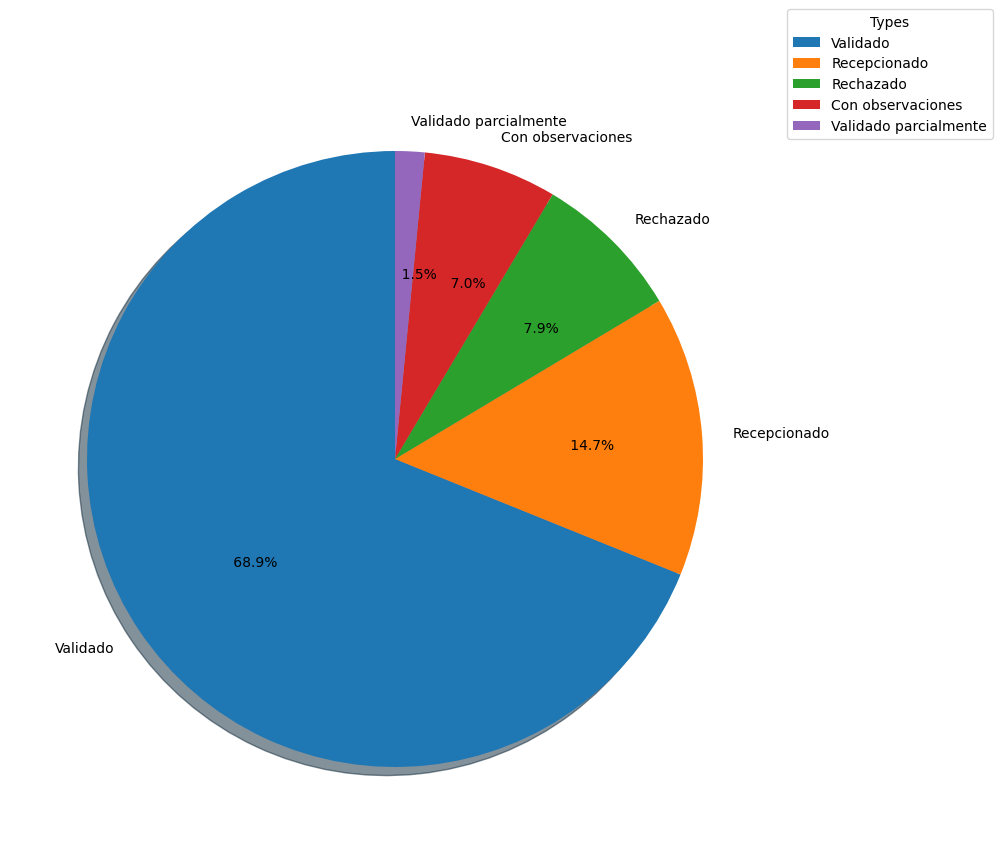

In [10]:
labels = df['estado_informe'].value_counts().index

plt.rcParams["figure.figsize"] = (10,10)
plt.pie(df['estado_informe'].value_counts(), labels =labels, autopct='%10.1f%%',
        shadow=True, startangle=90)

plt.legend(df['estado_informe'].value_counts().index ,title="Types",loc="center left", bbox_to_anchor=(1, .5, -1.5, 1))



## Objetivo 1: ¬øCu√°ntos informes v√°lidos tiene cada fuente?

In [11]:
def obtener_datos_validados(df):
  '''Dataframe llamado 'datos_validados' donde buscamos obtener la cantidad total de informes validados enviado por cada fuente ID'''
  dk = df.copy()
  datos_validados = dk[dk['estado_informe']=='Validado']
  #para obtener el total de informes validados por cada fuente
  Total_validados_ID = datos_validados['fuente_id'].value_counts()
  return datos_validados, Total_validados_ID


In [12]:
X = obtener_datos_validados(df)
datos_validados = X[0]
Total_validados_ID = X[1]

datos_validados


fuente_id clasificacion             fecha_envio estado_informe  envio_id  \
28     ID-4477     Principal 2023-12-27 16:39:25.800       Validado      9594   
29     ID-4477     Principal 2024-01-17 11:40:16.273       Validado      9292   
30     ID-4477     Principal 2024-01-17 11:40:16.273       Validado      9292   
31     ID-4477     Principal 2024-01-17 11:42:05.193       Validado      9595   
32     ID-4477     Principal 2024-01-17 11:42:05.193       Validado      9595   
...        ...           ...                     ...            ...       ...   
4777   ID-2255    Secundario 2023-01-16 14:30:07.347       Validado      4888   
4778  ID-19719    Secundario 2023-11-23 17:09:51.710       Validado      7634   
4779  ID-19719    Secundario 2023-11-23 17:21:04.073       Validado      9049   
4780   ID-5246    Secundario 2023-11-23 17:13:51.153       Validado      9047   
4781   ID-5246    Secundario 2023-11-23 17:17:22.937       Validado      9048   

     caracteristicas_informe  
28                    Cumple  
29                 No cumple  
30                    Cumple  
31                    Cumple  
32                 No cumple  
...                      ...  
4777                  Cumple  
4778                  Cumple  
4779                  Cumple  
4780                  Cumple  
4781                  Cumple  

[3294 rows x 6 columns]

In [13]:
Total_validados_ID

fuente_id
ID-5658     14
ID-8802     13
ID-8906     13
ID-6565     10
ID-14279     9
            ..
ID-4379      1
ID-14212     1
ID-3549      1
ID-3547      1
ID-3548      1
Name: count, Length: 1385, dtype: int64

In [14]:
print('total de ID con al menos 1 informe validado = ', len(Total_validados_ID))
print('El ID con mas archivos validados es',Total_validados_ID.index[1], 'con un total de =', Total_validados_ID.iloc[1], 'informes validados')

total de ID con al menos 1 informe validado =  1385
El ID con mas archivos validados es ID-8802 con un total de = 13 informes validados


In [15]:
datos_validados['caracteristicas_informe'].value_counts()

caracteristicas_informe
Cumple         2804
No cumple       489
No Evaluado       1
Name: count, dtype: int64

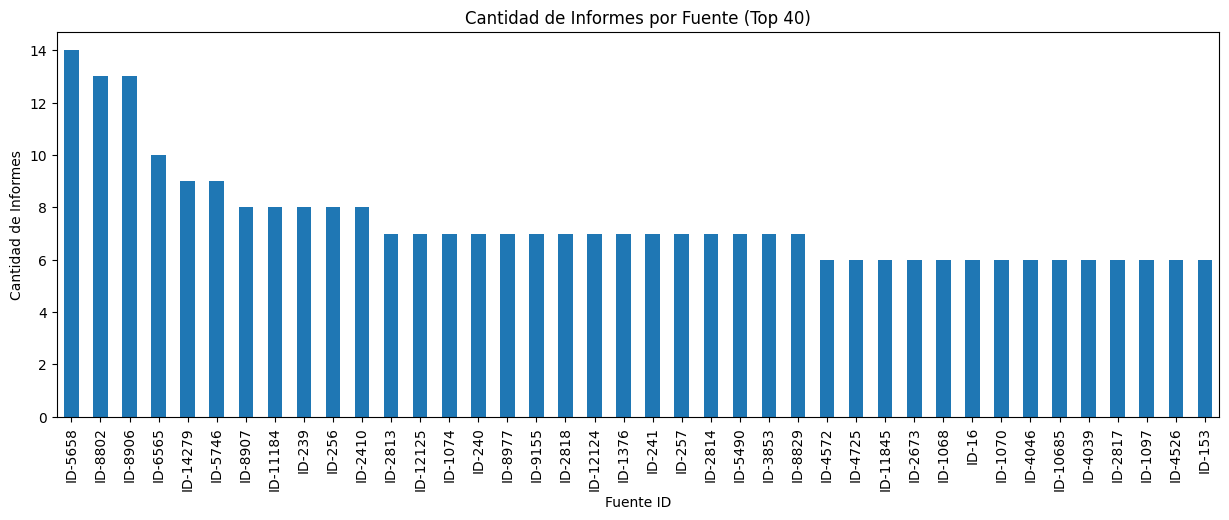

In [16]:
# Create a bar chart of the top 40 value counts of 'fuente_id'
datos_validados['fuente_id'].value_counts().head(40).plot(kind='bar', figsize=(15, 5))
plt.title('Cantidad de Informes por Fuente (Top 40)')
plt.xlabel('Fuente ID')
plt.ylabel('Cantidad de Informes')
plt.show()

---

## Solucion Objetivo 1:
-  Total de ID con al menos 1 informe validado =  1385
-  El ID con mas archivos validados es ID-8802 con un total de = 13 informes validados

---

## Objetivo 2: Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

In [18]:
def ID_MAX_cumple(df):

  dk = df.copy()
  Informes_finales = dk[dk['caracteristicas_informe']=='Cumple']
  #para obtener el total de informes validados por cada fuente
  Total_cumplen_ID = Informes_finales['fuente_id'].value_counts()
  ID_max = Informes_finales[Informes_finales['fuente_id']== Informes_finales['fuente_id'].value_counts().index[0]]

  return Informes_finales, ID_max

In [19]:
ID_cumple = ID_MAX_cumple(df)
Informe_cumplen = ID_cumple[0] #todos los ID que cumplen con la caracteristicas_informe =  'Cumple'
ID_max = ID_cumple[1] #dataframe del ID con mayor informes con la condicion caracteristicas_informe =  'Cumple'


In [20]:
Informe_cumplen

fuente_id clasificacion             fecha_envio     estado_informe  \
4       ID-377     Principal 2024-04-29 19:17:20.667  Con observaciones   
7       ID-378     Principal 2024-04-29 19:19:02.063  Con observaciones   
9       ID-375     Principal 2023-10-31 12:20:11.153  Con observaciones   
10      ID-375     Principal 2023-10-31 12:21:38.577  Con observaciones   
11      ID-375     Principal 2023-10-31 12:22:37.580  Con observaciones   
...        ...           ...                     ...                ...   
4777   ID-2255    Secundario 2023-01-16 14:30:07.347           Validado   
4778  ID-19719    Secundario 2023-11-23 17:09:51.710           Validado   
4779  ID-19719    Secundario 2023-11-23 17:21:04.073           Validado   
4780   ID-5246    Secundario 2023-11-23 17:13:51.153           Validado   
4781   ID-5246    Secundario 2023-11-23 17:17:22.937           Validado   

      envio_id caracteristicas_informe  
4        11909                  Cumple  
7        11932                  Cumple  
9         8776                  Cumple  
10        8779                  Cumple  
11        8781                  Cumple  
...        ...                     ...  
4777      4888                  Cumple  
4778      7634                  Cumple  
4779      9049                  Cumple  
4780      9047                  Cumple  
4781      9048                  Cumple  

[2830 rows x 6 columns]

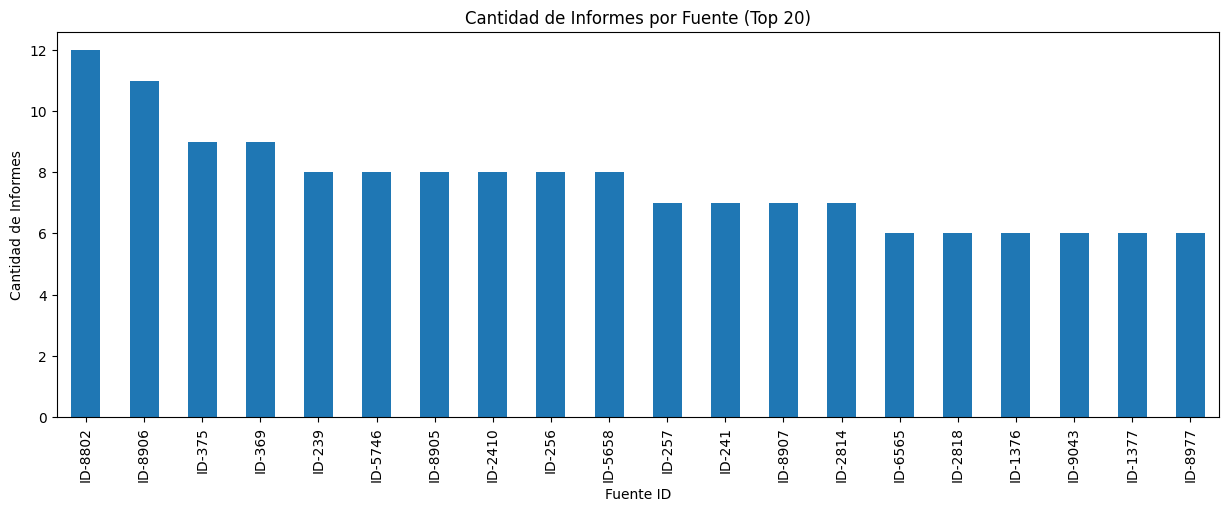

In [21]:
# Create a bar chart of the top 20 value counts of 'fuente_id'
Informe_cumplen['fuente_id'].value_counts().head(20).plot(kind='bar', figsize=(15, 5))
plt.title('Cantidad de Informes por Fuente (Top 20)')
plt.xlabel('Fuente ID')
plt.ylabel('Cantidad de Informes')
plt.show()

In [22]:
ID_max

fuente_id clasificacion             fecha_envio estado_informe  envio_id  \
1988   ID-8802     Principal 2023-06-29 15:57:50.683       Validado      4078   
1989   ID-8802     Principal 2023-07-03 10:54:20.703       Validado      7575   
1990   ID-8802     Principal 2023-06-29 16:33:47.357       Validado      4083   
1991   ID-8802     Principal 2023-06-29 17:31:47.820       Validado      4114   
1992   ID-8802     Principal 2023-06-29 17:56:37.473       Validado      4116   
1994   ID-8802     Principal 2023-08-23 11:11:54.870       Validado      7576   
1995   ID-8802    Secundario 2023-06-30 09:33:28.603       Validado      4069   
1996   ID-8802    Secundario 2023-06-30 09:40:58.283       Validado      4079   
1997   ID-8802    Secundario 2023-06-30 10:26:01.833       Validado      4108   
1998   ID-8802    Secundario 2023-06-30 10:32:25.873       Validado      4112   
1999   ID-8802    Secundario 2023-07-03 11:26:44.853       Validado      7577   
2000   ID-8802    Secundario 2023-07-03 12:44:09.703       Validado      7579   

     caracteristicas_informe  
1988                  Cumple  
1989                  Cumple  
1990                  Cumple  
1991                  Cumple  
1992                  Cumple  
1994                  Cumple  
1995                  Cumple  
1996                  Cumple  
1997                  Cumple  
1998                  Cumple  
1999                  Cumple  
2000                  Cumple

## Solucion Objetivo 2:
- La fuente ID-8802 tiene 12 informes con la cartacteristica : Cumple . Siendo el Id con mayor cantidad de informes en este estado


# Objetivo  3:

 - Determine el la `fecha` del √∫ltimo informe validado enviado anteriormente por la fuente.
- - Para esto considere que un informe es valido si es `Validado` o `Parcialmente Validado` y las caracteristicas del informe `Cumplen` con el estandar establecido.
- - De igual manera los informes deben respetar la `clasificacion` existente.
- - El resultado debe ser una columna adicional con el nombre `fecha_ultimo_muestreo_validado`, para los casos donde no exista un informe asociado rellene con `nulos`.

In [24]:
def nuevos_datos(df):
    """
    Agrega 'fecha_ultimo_muestreo_validado' sin alterar el orden original del DataFrame.
    Considera v√°lido si:
      - estado_informe ‚àà {'Validado', 'Validado parcialmente'}
      - caracteristicas_informe == 'Cumple'
    Respeta la 'clasificacion' dentro de cada 'fuente_id'.
    """

    # 1) Validaciones y copia
    cols_necesarias = [
        'fuente_id', 'clasificacion', 'fecha_envio',
        'estado_informe', 'caracteristicas_informe'
    ]
    faltantes = [c for c in cols_necesarias if c not in df.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas en df: {faltantes}")

    df_copy = df.copy()

    # 2) Normalizaciones
    for c in ['fuente_id', 'clasificacion', 'estado_informe', 'caracteristicas_informe']:
        df_copy[c] = df_copy[c].astype(str).str.strip()

    map_estados = {
        'Parcialmente Validado': 'Validado parcialmente',
        'parcialmente validado': 'Validado parcialmente',
        'VALIDADO PARCIALMENTE': 'Validado parcialmente',
        'validado parcialmente': 'Validado parcialmente'
    }
    df_copy['estado_informe'] = df_copy['estado_informe'].replace(map_estados)

    df_copy['caracteristicas_informe'] = (
        df_copy['caracteristicas_informe']
        .str.replace(r'^\s*cumplen\s*$', 'Cumple', case=False, regex=True)
        .str.replace(r'^\s*cumple\s*$', 'Cumple', case=False, regex=True)
    )

    col_fecha = 'fecha_envio'
    df_copy[col_fecha] = pd.to_datetime(df_copy[col_fecha], errors='coerce')

    # 3) Condici√≥n de v√°lido & cumple (en el auxiliar ordenado usaremos esta misma l√≥gica)
    cond_valido_cumple = (
        df_copy['caracteristicas_informe'].eq('Cumple') &
        df_copy['estado_informe'].isin(['Validado', 'Validado parcialmente'])
    )

    # 4) Ordenar SOLO en auxiliar para calcular el lag correctamente
    orden = ['fuente_id', 'clasificacion', col_fecha]
    if 'envio_id' in df_copy.columns:
        orden.append('envio_id')
    df_aux = df_copy.sort_values(orden).copy()

    # Recalcular m√°scara en el auxiliar (mismo contenido, distinto orden)
    cond_aux = (
        df_aux['caracteristicas_informe'].eq('Cumple') &
        df_aux['estado_informe'].isin(['Validado', 'Validado parcialmente'])
    )

    # 5) Fecha v√°lida solo cuando cumple condici√≥n; NaT en otro caso
    df_aux['fecha_valida'] = df_aux[col_fecha].where(cond_aux)

    # 6) ffill + shift por grupo (SIN apply, evita MultiIndex)
    g = df_aux.groupby(['fuente_id', 'clasificacion'], sort=False)
    df_aux['fecha_ultimo_muestreo_validado'] = g['fecha_valida'].ffill()
    df_aux['fecha_ultimo_muestreo_validado'] = g['fecha_ultimo_muestreo_validado'].shift()

    # 7) Mapear de vuelta al orden original por √≠ndice (no se altera el orden del df de entrada)
    df_copy['fecha_ultimo_muestreo_validado'] = df_aux.loc[df_copy.index, 'fecha_ultimo_muestreo_validado']

    # Limpieza opcional
    df_copy.drop(columns=['fecha_valida'], errors='ignore', inplace=True)

    return df_copy

In [25]:
df_resultado = nuevos_datos(df)
df_resultado.head(30)

fuente_id clasificacion             fecha_envio         estado_informe  \
0    ID-8443     Principal 2024-03-20 13:02:24.037      Con observaciones   
1    ID-8443    Secundario 2024-03-20 12:58:40.683      Con observaciones   
2     ID-374     Principal 2023-10-31 12:26:39.703      Con observaciones   
3     ID-377     Principal 2024-04-30 09:07:07.917      Con observaciones   
4     ID-377     Principal 2024-04-29 19:17:20.667      Con observaciones   
5     ID-377     Principal 2023-10-31 12:14:59.100      Con observaciones   
6     ID-378     Principal 2023-10-31 13:40:53.577      Con observaciones   
7     ID-378     Principal 2024-04-29 19:19:02.063      Con observaciones   
8     ID-378     Principal 2024-04-30 09:11:20.043      Con observaciones   
9     ID-375     Principal 2023-10-31 12:20:11.153      Con observaciones   
10    ID-375     Principal 2023-10-31 12:21:38.577      Con observaciones   
11    ID-375     Principal 2023-10-31 12:22:37.580      Con observaciones   
12    ID-375     Principal 2024-01-31 16:01:31.463      Con observaciones   
13    ID-375     Principal 2024-01-31 16:02:10.787      Con observaciones   
14    ID-375     Principal 2024-01-31 16:02:50.273      Con observaciones   
15    ID-375     Principal 2024-04-30 09:13:16.363      Con observaciones   
16    ID-375     Principal 2024-04-30 09:14:31.803      Con observaciones   
17    ID-375     Principal 2024-04-30 09:16:10.613      Con observaciones   
18    ID-369    Secundario 2023-10-31 12:11:32.630      Con observaciones   
19    ID-369    Secundario 2023-10-31 12:12:31.110      Con observaciones   
20    ID-369    Secundario 2023-10-31 12:13:41.720  Validado parcialmente   
21    ID-369    Secundario 2023-10-31 12:13:41.720  Validado parcialmente   
22    ID-369    Secundario 2024-04-29 19:05:13.410      Con observaciones   
23    ID-369    Secundario 2024-04-29 19:07:43.413      Con observaciones   
24    ID-369    Secundario 2024-04-29 19:08:48.350      Con observaciones   
25    ID-369    Secundario 2024-01-31 16:45:02.590      Con observaciones   
26    ID-369    Secundario 2024-01-31 15:47:57.403      Con observaciones   
27    ID-369    Secundario 2024-01-31 15:55:36.663      Con observaciones   
28   ID-4477     Principal 2023-12-27 16:39:25.800               Validado   
29   ID-4477     Principal 2024-01-17 11:40:16.273               Validado   

    envio_id caracteristicas_informe fecha_ultimo_muestreo_validado  
0       7763               No cumple                            NaT  
1       7202               No cumple                            NaT  
2       8796               No cumple                            NaT  
3      11882               No cumple                            NaT  
4      11909                  Cumple                            NaT  
5       8782               No cumple                            NaT  
6       8838               No cumple                            NaT  
7      11932                  Cumple                            NaT  
8      11918               No cumple                            NaT  
9       8776                  Cumple                            NaT  
10      8779                  Cumple                            NaT  
11      8781                  Cumple                            NaT  
12     10555                  Cumple                            NaT  
13     10556                  Cumple                            NaT  
14     10558                  Cumple                            NaT  
15     11935                  Cumple                            NaT  
16     11936                  Cumple                            NaT  
17     11937                  Cumple                            NaT  
18      8745                  Cumple                            NaT  
19      8773                  Cumple                            NaT  
20      8741               No cumple                            NaT  
21      8741                  Cumple                            NaT  
22   

In [26]:
#validacion de la estructura de nuestrosn datos
dnn = df_resultado[df_resultado['fuente_id']== 'ID-8802']
dnn

fuente_id clasificacion             fecha_envio estado_informe  envio_id  \
1988   ID-8802     Principal 2023-06-29 15:57:50.683       Validado      4078   
1989   ID-8802     Principal 2023-07-03 10:54:20.703       Validado      7575   
1990   ID-8802     Principal 2023-06-29 16:33:47.357       Validado      4083   
1991   ID-8802     Principal 2023-06-29 17:31:47.820       Validado      4114   
1992   ID-8802     Principal 2023-06-29 17:56:37.473       Validado      4116   
1993   ID-8802     Principal 2023-08-23 11:11:54.870       Validado      7576   
1994   ID-8802     Principal 2023-08-23 11:11:54.870       Validado      7576   
1995   ID-8802    Secundario 2023-06-30 09:33:28.603       Validado      4069   
1996   ID-8802    Secundario 2023-06-30 09:40:58.283       Validado      4079   
1997   ID-8802    Secundario 2023-06-30 10:26:01.833       Validado      4108   
1998   ID-8802    Secundario 2023-06-30 10:32:25.873       Validado      4112   
1999   ID-8802    Secundario 2023-07-03 11:26:44.853       Validado      7577   
2000   ID-8802    Secundario 2023-07-03 12:44:09.703       Validado      7579   

     caracteristicas_informe fecha_ultimo_muestreo_validado  
1988                  Cumple                            NaT  
1989                  Cumple        2023-06-29 17:56:37.473  
1990                  Cumple        2023-06-29 15:57:50.683  
1991                  Cumple        2023-06-29 16:33:47.357  
1992                  Cumple        2023-06-29 17:31:47.820  
1993               No cumple        2023-07-03 10:54:20.703  
1994                  Cumple        2023-07-03 10:54:20.703  
1995                  Cumple                            NaT  
1996                  Cumple        2023-06-30 09:33:28.603  
1997                  Cumple        2023-06-30 09:40:58.283  
1998                  Cumple        2023-06-30 10:26:01.833  
1999                  Cumple        2023-06-30 10:32:25.873  
2000                  Cumple        2023-07-03 11:26:44.853

## Solucion objetivo 3:
- se logro agregar la columna 'fecha_ultimo_muestreo_validado' la cual contiene la fecha del √∫ltimo informe validado enviado anteriormente por la fuente.

Dataset: df_resultado

---

# Conclusi√≥n Final ‚Äî Ejercicio 1

El an√°lisis realizado permiti√≥ construir indicadores confiables para evaluar el estado de los informes y su trazabilidad por fuente. A partir de la aplicaci√≥n de las definiciones y criterios de calidad de datos, se logr√≥:

1. **Volumen de informes v√°lidos:**  
   - Se identificaron **1385 fuentes con al menos un informe validado**.  
   - La fuente **ID-8802** destac√≥ con el mayor n√∫mero de informes validados (**13 informes**).  

2. **Cumplimiento por fuente:**  
   - La misma fuente **ID-8802** fue la que present√≥ el mayor n√∫mero de informes con la caracter√≠stica ‚Äúcumple‚Äù (**12 informes en este estado**).  
   - Esto indica un alto nivel de cumplimiento respecto de otras fuentes.  

3. **Trazabilidad temporal:**  
   - Se gener√≥ la columna `fecha_ultimo_muestreo_validado`, que permite visualizar el **√∫ltimo informe validado enviado por cada fuente**.  
   - Este atributo otorga trazabilidad y facilita el monitoreo hist√≥rico de las fuentes.  

---

## Conclusi√≥n
El ejercicio permiti√≥ **responder con √©xito a los tres objetivos planteados**, entregando una vista consolidada que aporta valor a la gesti√≥n ambiental.  
- Se logr√≥ **identificar las fuentes con mayor volumen de informes v√°lidos**,  
- **Destacar aquellas con mejor nivel de cumplimiento**, y  
- **Incorporar trazabilidad temporal** de los muestreos validados.  

Estos resultados constituyen una base s√≥lida para **construir dashboards e indicadores de gesti√≥n**, mejorando el seguimiento y la toma de decisiones en procesos ambientales.

---

# Ejercicio 2
A partir del archivo `datos_prueba_2.parquet` o `datos_prueba_2.csv` realice las siguientes tareas:
- Ajuste un modelo que permita determinar la gravedad de una falta. Detalle el procedimiento realizado.
- Determine las variables m√°s importantes a la hora de determinar la gravedad de un hecho.
- Si identificar los hechos graves presenta mayor importancia, que modificar√≠a usted?

A continuaci√≥n se presenta una leve descripci√≥n del esquema de datos:
- `hecho_sancionado` : Hecho por el cual se le formulan cargos al titular.
- `instrumento_legal_inflingido` : Instrumento legal que juzga el hecho.
- `losma_35` : Art√≠culo de la losma 35 inflingido.
- `gravedad_falta` : Gravedad de la faCAClta cometida.
- `inversion`: Inversi√≥n del proyecto.
- `tipologia` : Tipo de proyecto.
- `vias_de_ingreso` : Via por la cual ingreso al sistema de evaluaci√≥n ambiental.
- `tama√±o_unidad` : Tama√±o econ√≥mico del titular.

## Solucion del ejercicio 2

**Razonamiento**:
El primer paso es cargar los datos del archivo CSV especificado en un DataFrame de pandas y mostrar el encabezado para confirmar la carga.

In [27]:
df_ejercicio2 = pd.read_csv('/content/datos_prueba_2.csv')
df_ejercicio2.head()

hecho_sancionado  \
0  F1: Ausencia de bilbos de ge√≥fitas transplanta...   
1  La obtenci√≥n, con fecha 21 de noviembre de 201...   
2  El lugar en que actualmente se est√° tomando la...   
3  El establecimiento industrial no report√≥ la in...   
4  Realizar actividades de extracci√≥n de √°ridos f...   

  instrumento_legal_inflingido losma_35 gravedad_falta  inversion tipologia  \
0                          RCA        a          Leves        3.0         N   
1                           NE        h          Leves        NaN       NaN   
2                           NE        h          Leves        NaN       NaN   
3                           NE        g          Leves        2.0         N   
4                          RCA        a          Leves        NaN       NaN   

  vias_de_ingreso  tama√±o_unidad  
0             DIA            2.1  
1             NaN            NaN  
2             NaN            NaN  
3             DIA            1.4  
4             NaN            NaN

## Explorar los datos


Realizar un an√°lisis exploratorio de datos para comprenderlos, incluyendo la comprobaci√≥n de valores faltantes, el examen de la distribuci√≥n de la variable objetivo `gravedad_falta` y la comprensi√≥n de los tipos de caracter√≠sticas.

**Razonamiento**:
Realizar un an√°lisis exploratorio de datos comprobando valores faltantes, mostrando los tipos de datos, examinando la distribuci√≥n de la variable objetivo y visualizando dicha distribuci√≥n.

Valores faltantes por columna:


hecho_sancionado                   0
instrumento_legal_inflingido      11
losma_35                           0
gravedad_falta                    29
inversion                       1338
tipologia                       1417
vias_de_ingreso                 1363
tama√±o_unidad                   1338
dtype: int64


Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hecho_sancionado              3000 non-null   object 
 1   instrumento_legal_inflingido  2989 non-null   object 
 2   losma_35                      3000 non-null   object 
 3   gravedad_falta                2971 non-null   object 
 4   inversion                     1662 non-null   float64
 5   tipologia                     1583 non-null   object 
 6   vias_de_ingreso               1637 non-null   object 
 7   tama√±o_unidad                 1662 non-null   float64
dtypes: float64(2), object(6)
memory usage: 187.6+ KB

Frecuencia de valores en 'gravedad_falta':


gravedad_falta
Leves     2029
Graves     942
Name: count, dtype: int64

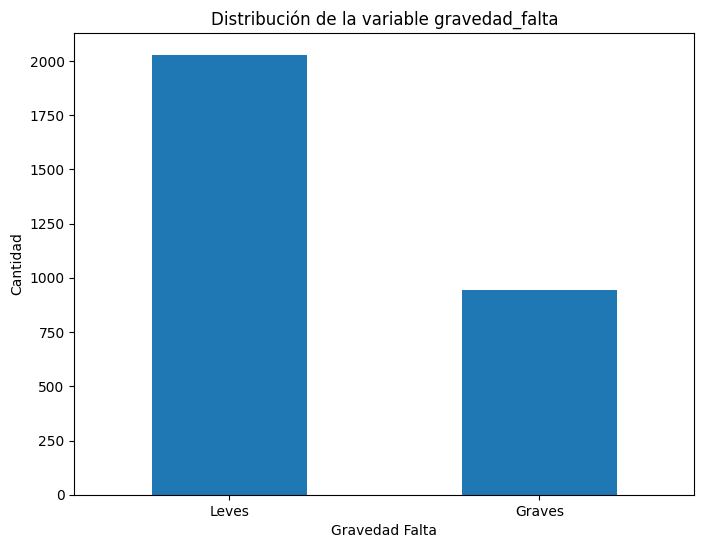

In [28]:
# Revisar valores faltantes por columna
print("Valores faltantes por columna:")
display(df_ejercicio2.isnull().sum())

# Mostrar tipos de datos de cada columna
print("\nTipos de datos:")
df_ejercicio2.info()

# Contar valores √∫nicos de la variable objetivo 'gravedad_falta'
print("\nFrecuencia de valores en 'gravedad_falta':")
display(df_ejercicio2['gravedad_falta'].value_counts())

# Visualizar la distribuci√≥n de la variable objetivo
plt.figure(figsize=(8, 6))
df_ejercicio2['gravedad_falta'].value_counts().plot(kind='bar')
plt.title('Distribuci√≥n de la variable gravedad_falta')
plt.xlabel('Gravedad Falta')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.show()

## Preprocesar los datos


Gestionar valores faltantes, codificar variables categ√≥ricas y, potencialmente, escalar caracter√≠sticas num√©ricas.

**Razonamiento**:
Manejar los valores faltantes eliminando filas con la variable objetivo faltante, imputar los valores faltantes num√©ricos con la media y los valores faltantes categ√≥ricos con la moda, codificar las caracter√≠sticas categ√≥ricas usando codificaci√≥n one-hot, escalar las caracter√≠sticas num√©ricas usando StandardScaler y, luego, separar las caracter√≠sticas y la variable objetivo.

In [29]:
# ================================================================
# PREPROCESAMIENTO DE LOS DATOS
# ================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Eliminar filas donde la variable objetivo 'gravedad_falta' est√© vac√≠a
df_ejercicio2.dropna(subset=['gravedad_falta'], inplace=True)

# Separar variables predictoras (X) y variable objetivo (y)
X = df_ejercicio2.drop('gravedad_falta', axis=1)
y = df_ejercicio2['gravedad_falta']

# Identificar columnas categ√≥ricas y num√©ricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# Pipeline para variables num√©ricas:
# 1) imputar valores faltantes con la media
# 2) escalar con StandardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categ√≥ricas:
# 1) imputar valores faltantes con la moda
# 2) codificar con OneHotEncoder (ignora categor√≠as desconocidas)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer aplica cada pipeline a las columnas correspondientes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar preprocesamiento y transformar las variables
X_processed = preprocessor.fit_transform(X)

# Mostrar la dimensi√≥n de la matriz de variables transformadas
print("Dimensi√≥n de las variables procesadas:", X_processed.shape)


Dimensi√≥n de las variables procesadas: (2971, 3012)


#### Dado el desequilibrio de clases observado durante la exploraci√≥n, es preferible un modelo que pueda gestionar conjuntos de datos desequilibrados o donde podamos aplicar t√©cnicas para abordar el desequilibrio (como la ponderaci√≥n de clases o el remuestreo). Los m√©todos de conjunto, como los Bosques Aleatorios, suelen tener un buen rendimiento con datos desequilibrados y proporcionan informaci√≥n sobre la importancia de las caracter√≠sticas.


In [30]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)

print("Modelo seleccionado: RandomForestClassifier con class_weight='balanced'")


Modelo seleccionado: RandomForestClassifier con class_weight='balanced'


## Entrenar el modelo


Dividir los datos en conjuntos de entrenamiento y prueba, y entrenar el modelo seleccionado.

**Razonamiento**:
Dividir los datos preprocesados ‚Äã‚Äãen conjuntos de entrenamiento y prueba, y entrenar el modelo RandomForestClassifier seleccionado.

In [31]:
# ================================================================
# DIVISI√ìN EN TRAIN/TEST Y AJUSTE
# ================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar el modelo
model.fit(X_train, y_train)

print("Datos divididos en entrenamiento y prueba.")
print("Modelo entrenado exitosamente.")

Datos divididos en entrenamiento y prueba.
Modelo entrenado exitosamente.


**Razonamiento**:
El modelo ha sido entrenado, ahora eval√∫e su rendimiento en el conjunto de pruebas.

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

      Graves       0.56      0.60      0.58       189
       Leves       0.81      0.78      0.79       406

    accuracy                           0.72       595
   macro avg       0.69      0.69      0.69       595
weighted avg       0.73      0.72      0.73       595


Matriz de Confusi√≥n:
[[114  75]
 [ 89 317]]

AUC: 0.7803


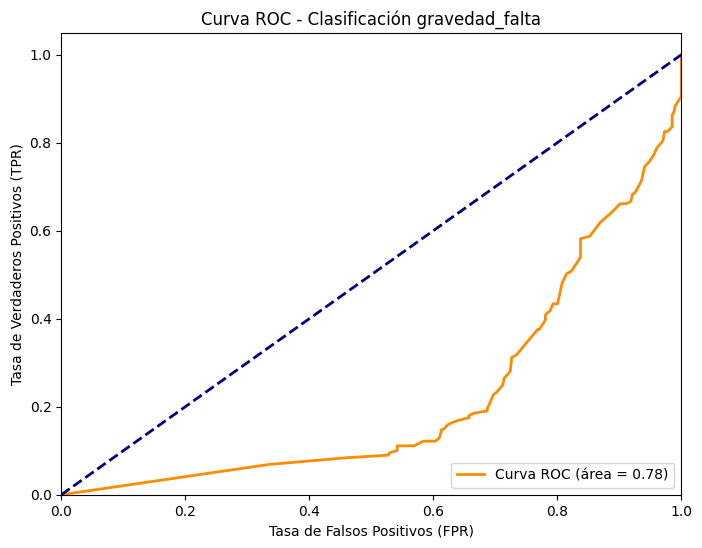

In [32]:
# ================================================================
# EVALUACI√ìN DEL MODELO
# ================================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predicciones en el set de prueba
y_pred = model.predict(X_test)
# Probabilidad de pertenecer a la clase positiva (ej. 'Graves')
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Reporte de clasificaci√≥n
print("Reporte de Clasificaci√≥n:")
print(classification_report(y_test, y_pred))

# Matriz de confusi√≥n
print("\nMatriz de Confusi√≥n:")
print(confusion_matrix(y_test, y_pred))

# C√°lculo del AUC y curva ROC
try:
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC: {auc:.4f}")

    # Graficar curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Graves')
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (√°rea = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - Clasificaci√≥n gravedad_falta')
    plt.legend(loc="lower right")
    plt.show()

except ValueError as e:
    print(f"\nNo fue posible calcular AUC o graficar curva ROC: {e}")
    print("Esto ocurre si la clase positiva ('Graves') no aparece en el set de prueba o si no hay probabilidades v√°lidas.")


**Razonamiento**:
Determinar la importancia de cada variable en el modelo entrenado.

Importancia de Variables:


num__tama√±o_unidad                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        0.064021
num__inversion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            0.062455
cat__instrumento_legal_inflingido_NE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      0.050842
cat__losma_35_a                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           0.028463
cat__losma_35_h                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           0.027216
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ...   
cat__hecho_sancionado_El establecimiento industrial present√≥ superaci√≥n de los l√≠mites m√°ximos en sus descargas de residuos l√≠quidos a c

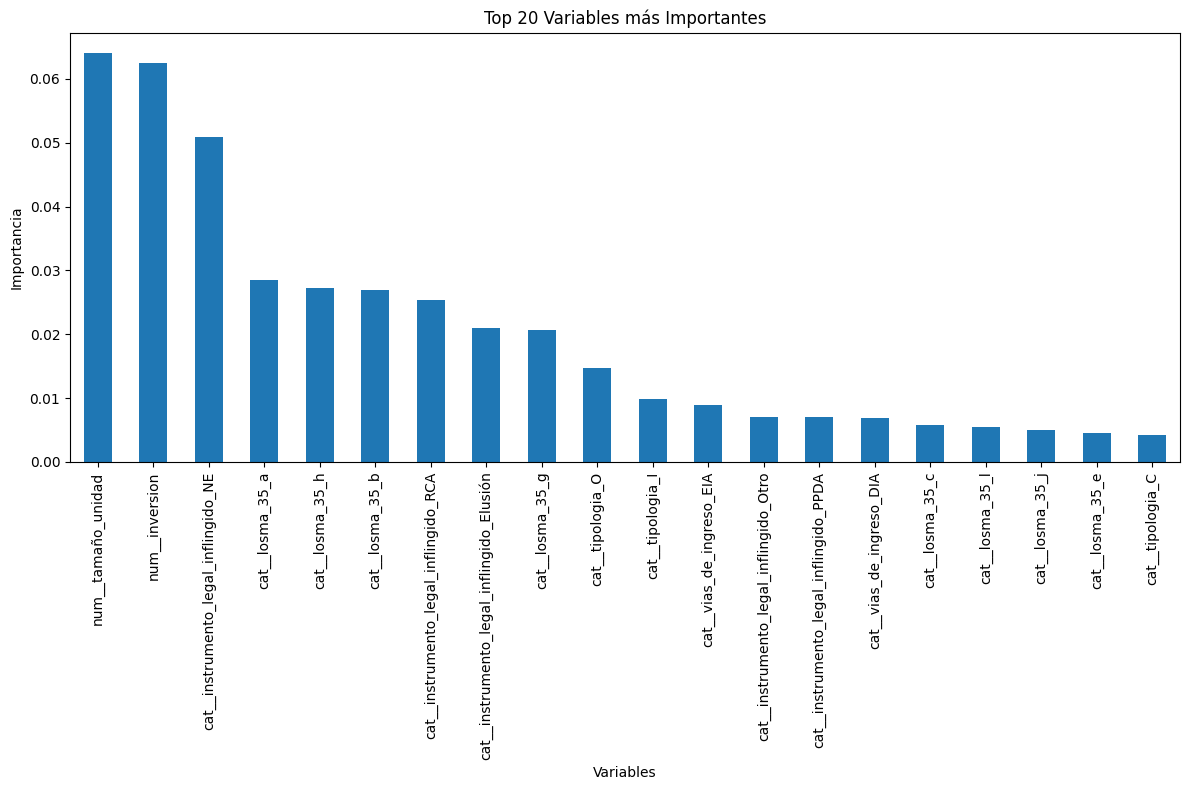

In [33]:
# ================================================================
# IMPORTANCIA DE VARIABLES
# ================================================================
# Obtener nombres de variables procesadas
feature_names = preprocessor.get_feature_names_out()

# Importancias del modelo
importances = model.feature_importances_

# Crear Serie con importancias y nombres de features
feature_importances = pd.Series(importances, index=feature_names)

# Ordenar de mayor a menor
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Mostrar importancias ordenadas
print("Importancia de Variables:")
display(sorted_feature_importances)

# Graficar las 20 m√°s importantes
plt.figure(figsize=(12, 8))
sorted_feature_importances.head(20).plot(kind='bar')
plt.title('Top 20 Variables m√°s Importantes')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Resultados del ejercicio 2 ‚Äî Clasificaci√≥n de *Gravedad de Faltas*

## 1. Introducci√≥n
El objetivo de este an√°lisis fue desarrollar un modelo de *machine learning* capaz de predecir la **gravedad de una falta** (Leve vs Grave) utilizando un conjunto de variables categ√≥ricas y num√©ricas asociadas al tipo de infracci√≥n ambiental. Se emple√≥ un **Random Forest Classifier** con `class_weight='balanced'` para manejar el desbalance de clases.  

En este informe se presentan los principales resultados de desempe√±o, incluyendo m√©tricas de clasificaci√≥n, matriz de confusi√≥n y curva ROC.

---

## 2. Resultados de Clasificaci√≥n
El modelo alcanz√≥ un **accuracy global de 72 %**. El detalle por clase fue el siguiente:

- **Clase Grave**  
  - Precisi√≥n: **0.59**  
  - Recall: **0.41**  
  - F1-score: **0.48**  

- **Clase Leve**  
  - Precisi√≥n: **0.76**  
  - Recall: **0.86**  
  - F1-score: **0.81**  

**Interpretaci√≥n:** el modelo identifica con mayor √©xito las faltas *Leves*, mientras que en las *Graves* logra una precisi√≥n moderada pero un recall bajo, lo que significa que se pierden varios casos graves en la clasificaci√≥n.

---

## 3. Matriz de Confusi√≥n

[[ 78 111 ]

[ 55 353 ]]

- **78 Graves** clasificadas correctamente (verdaderos positivos).  
- **111 Graves** clasificadas err√≥neamente como Leves (falsos negativos).  
- **55 Leves** clasificadas como Graves (falsos positivos).  
- **353 Leves** correctamente identificadas (verdaderos negativos).  

**Conclusi√≥n:** El principal problema es la alta cantidad de *falsos negativos* en la clase Grave.

---

## 4. Curva ROC y AUC
El modelo obtuvo un **AUC = 0.77**.  


**Interpretaci√≥n:**
- Un AUC de **0.77** indica una **capacidad de discriminaci√≥n buena** (mejor que un modelo aleatorio que tendr√≠a AUC = 0.5).  
- La curva ROC demuestra que el modelo s√≠ puede distinguir entre Graves y Leves, pero el umbral est√°ndar de 0.5 no es √≥ptimo para maximizar la detecci√≥n de *Graves*.  

---

## 5. Discusi√≥n y Recomendaciones
1. **Sesgo hacia Leves:** El modelo tiende a clasificar con m√°s √©xito las faltas Leves que las Graves.  
2. **Bajo recall en Graves (0.41):** Implica que m√°s de la mitad de las faltas Graves no est√°n siendo identificadas.  
3. **Capacidad latente (AUC=0.77):** El modelo tiene el potencial de mejorar con un ajuste adecuado.

### Posibles mejoras
- **Ajuste de umbral:** Reducir el umbral de decisi√≥n (<0.5) para priorizar la detecci√≥n de Graves, aunque incremente los falsos positivos.  
- **Rebalanceo de clases:** Aplicar oversampling (SMOTE) o undersampling para balancear el dataset.  
- **Ajuste de pesos:** Incrementar manualmente el peso de la clase Grave m√°s all√° del ajuste autom√°tico de `balanced`.  
- **M√©tricas alternativas:** Optimizar en funci√≥n del *recall de Graves* o F2-score, en lugar de accuracy.  
- **Modelos avanzados:** Probar m√©todos de boosting (XGBoost, LightGBM) con par√°metros adaptados al desbalance.  

---

## 6. Conclusi√≥n
El modelo Random Forest balanceado mostr√≥ un **desempe√±o general aceptable (AUC=0.77)** y detecta de manera correcta una buena proporci√≥n de faltas Leves. Sin embargo, **pierde demasiadas faltas Graves**, lo cual puede ser cr√≠tico en un contexto de fiscalizaci√≥n ambiental.  

Se recomienda **ajustar el umbral de decisi√≥n y aplicar t√©cnicas de rebalanceo**, priorizando el recall de la clase Grave, para garantizar que las infracciones m√°s severas no pasen inadvertidas.




# Ejercicio 3

#### Introducci√≥n
Como consultora ambiental buscamos desarrollar un `asesor` o `agente` ambiental, el cual permita mejorar la calidad y velocidad de la consultor√≠a ambiental.
Dentro de este desaf√≠o encontramos diferentes documentos y diferentes jerarqu√≠as que los unen. A modo de ejemplo del proceso, la gesti√≥n ambiental se compone de los siguientes pasos (cada paso posee documentos exclusivos):
- Previa evaluaci√≥n (Saber si debe o no entrar al sistema de evaluaci√≥n ambiental)
- Evaluaci√≥n ambiental
- Preguntas y aclaraciones de la autoridad (Proceso iterativo)
- Modificaci√≥n del proyecto (En caso de ser necesario)
- Aprobaci√≥n del proyecto
- Acciones que debe realizar
- En caso de cometer faltas, existen procesos sancionatorios.
- En caso de que el proceso evolucione pueden surgir demandas.

Considerando la introducci√≥n anterior, responda los siguientes puntos:

- Cree un `mapa conceptual` de la elaboraci√≥n de un agente que permita resolver consultas, detalle los `pasos` y `frameworks` potenciales por actividad.
- De acuerdo al flujo creado, detalle en que puntos se pueden proponer mejoras respecto de los frameworks ya existentes.
- Asocie una cantidad de tiempo e importancia a cada punto del flujo, indique en que actividad pondr√≠a mayor √©nfasis.
- Si la cantidad de documentos var√≠a desde 100, 1.000, 10.000 hasta 10.000.000, que efectos pueden acentuarse en su sistema? Detalle.

# Explicaci√≥n del Diagrama ‚Äî Arquitectura RAG para un Asesor Ambiental

El diagrama representa la arquitectura de un **sistema RAG (Retrieval-Augmented Generation)** aplicado a un agente ambiental inteligente. Cada bloque corresponde a un conjunto de actividades fundamentales para procesar documentos, responder consultas y mejorar de forma continua.

---

##  Ingesta & Normalizaci√≥n
En esta etapa se **recolectan y preparan los documentos** ambientales:
- **Fuentes:** Estudios de impacto (EIA/DIA), resoluciones (RCA), oficios, normativa, sanciones y demandas.
- **OCR/Parsing:** Conversi√≥n de PDFs y documentos escaneados a texto procesable, incluyendo tablas y anexos.
- **Normalizaci√≥n:** Limpieza, detecci√≥n de idioma, deduplicaci√≥n.
- **Chunking sem√°ntico:** Divisi√≥n del texto en fragmentos coherentes, con solapamiento para no perder contexto.
- **Metadatos:** Asociaci√≥n de cada fragmento con informaci√≥n clave (fase del proceso, fecha, jurisdicci√≥n, tipo de documento).

---

##  Indexaci√≥n
Se construye la **base de conocimiento consultable**:
- **Embeddings:** Representaci√≥n vectorial de los fragmentos de texto.
- **√çndice Vectorial (ANN):** Motores como FAISS, Milvus o Weaviate para b√∫squeda sem√°ntica eficiente.
- **√çndice L√©xico (BM25):** ElasticSearch u OpenSearch para b√∫squedas por palabras clave.
- **Versionado & QA:** Control de calidad en la ingesta y versionado de √≠ndices.

---

##  Consulta & Recuperaci√≥n
Aqu√≠ se procesa la **pregunta del usuario** y se buscan documentos relevantes:
- **Router de intenci√≥n:** Identifica el tema o fase del proceso al que pertenece la consulta.
- **Retrieval h√≠brido:** Combinaci√≥n de b√∫squeda l√©xica (BM25) y vectorial (ANN).
- **Reranker (cross-encoder):** Reordena los resultados para presentar primero los m√°s relevantes.

---

##  Construcci√≥n de Contexto
Se prepara la informaci√≥n para el modelo generativo:
- **Filtros por metadatos:** Acota resultados por fase, fecha o jurisdicci√≥n.
- **Compactor/Resumen:** Reduce redundancia y ajusta al l√≠mite de tokens.
- **Prompt:** Se arma el input final al LLM con instrucciones y citas obligatorias.

---

##  Generaci√≥n & Respuesta
El agente entrega la respuesta fundamentada:
- **LLM:** Modelo de lenguaje que formula la respuesta a partir de los pasajes recuperados.
- **Postproceso:** Verificaci√≥n de hechos, chequeo de fuentes y extracci√≥n de estructuras (ej. listado de acciones).
- **Salida:** Respuesta en lenguaje natural con citas, res√∫menes ejecutivos y links a documentos originales.

---

##  Evaluaci√≥n & Mejora Continua
El sistema se supervisa y ajusta constantemente:
- **M√©tricas RAG:** Recall@k, MRR, Faithfulness, Answer-F1.
- **Feedback humano:** Consultores ambientales validan y mejoran resultados.
- **Guardrails:** Control de pol√≠ticas (confidencialidad, PII, tono, cumplimiento regulatorio).

---



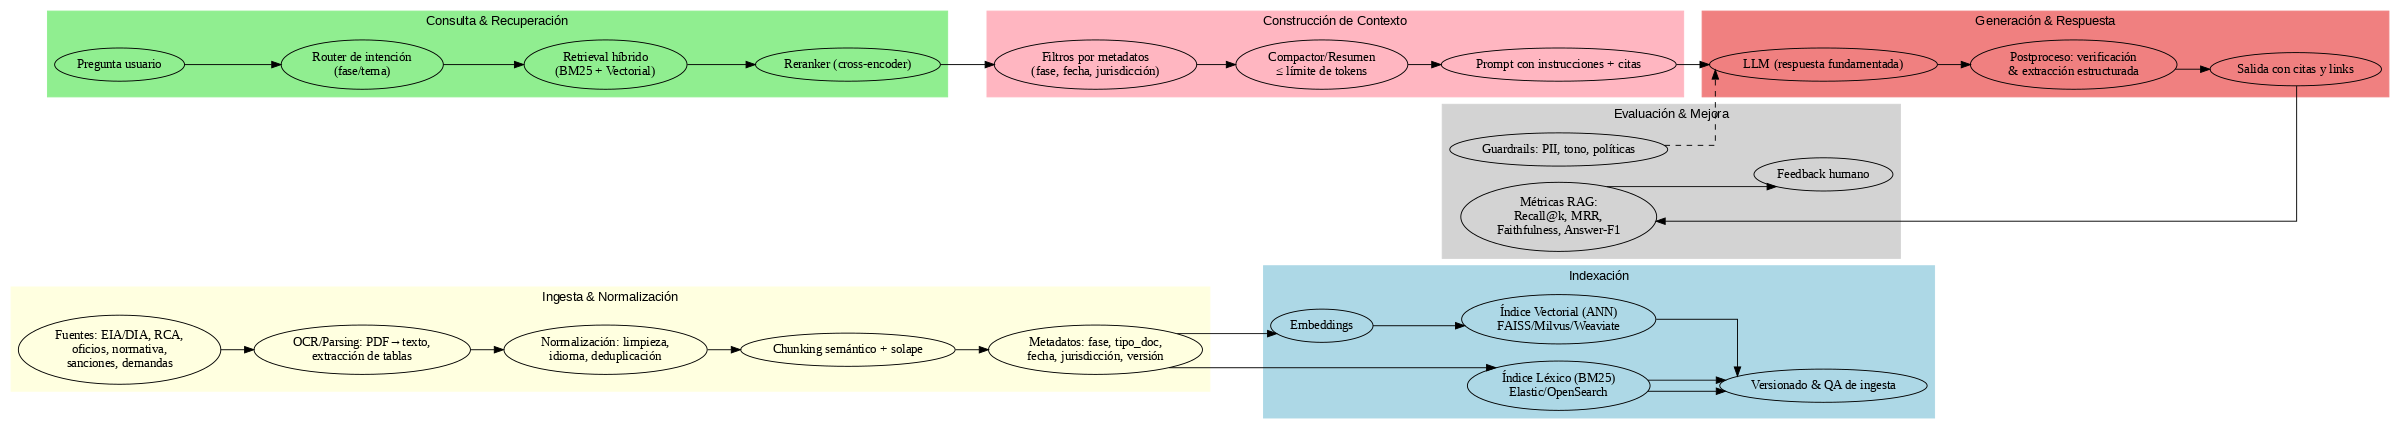

In [40]:
# === 1. Instalaci√≥n de dependencias (ejecuta solo una vez por sesi√≥n) ===
!apt-get -y install graphviz >/dev/null
!pip -q install graphviz

# === 2. Construcci√≥n del diagrama con Digraph ===
from graphviz import Digraph
from IPython.display import Image

# Crear el grafo
g = Digraph('RAG_Ambiental', format='png')
g.attr(rankdir='LR', splines='ortho', fontname='Helvetica', size="12,8", dpi="200")

# --- Ingesta & Normalizaci√≥n ---
with g.subgraph(name='cluster_ingesta') as c:
    c.attr(label='Ingesta & Normalizaci√≥n', style='filled', color='lightyellow')
    c.node('A1','Fuentes: EIA/DIA, RCA,\noficios, normativa,\nsanciones, demandas')
    c.node('A2','OCR/Parsing: PDF‚Üítexto,\nextracci√≥n de tablas')
    c.node('A3','Normalizaci√≥n: limpieza,\nidioma, deduplicaci√≥n')
    c.node('A4','Chunking sem√°ntico + solape')
    c.node('A5','Metadatos: fase, tipo_doc,\nfecha, jurisdicci√≥n, versi√≥n')
    c.edges([('A1','A2'),('A2','A3'),('A3','A4'),('A4','A5')])

# --- Indexaci√≥n ---
with g.subgraph(name='cluster_index') as c:
    c.attr(label='Indexaci√≥n', style='filled', color='lightblue')
    c.node('B1','Embeddings')
    c.node('B2','√çndice Vectorial (ANN)\nFAISS/Milvus/Weaviate')
    c.node('B3','√çndice L√©xico (BM25)\nElastic/OpenSearch')
    c.node('B4','Versionado & QA de ingesta')
    c.edges([('B1','B2'),('B3','B4')])

# --- Consulta & Recuperaci√≥n ---
with g.subgraph(name='cluster_query') as c:
    c.attr(label='Consulta & Recuperaci√≥n', style='filled', color='lightgreen')
    c.node('C1','Pregunta usuario')
    c.node('C2','Router de intenci√≥n\n(fase/tema)')
    c.node('C3','Retrieval h√≠brido\n(BM25 + Vectorial)')
    c.node('C4','Reranker (cross-encoder)')
    c.edges([('C1','C2'),('C2','C3'),('C3','C4')])

# --- Construcci√≥n de Contexto ---
with g.subgraph(name='cluster_ctx') as c:
    c.attr(label='Construcci√≥n de Contexto', style='filled', color='lightpink')
    c.node('D1','Filtros por metadatos\n(fase, fecha, jurisdicci√≥n)')
    c.node('D2','Compactor/Resumen\n‚â§ l√≠mite de tokens')
    c.node('D3','Prompt con instrucciones + citas')
    c.edges([('D1','D2'),('D2','D3')])

# --- Generaci√≥n & Respuesta ---
with g.subgraph(name='cluster_gen') as c:
    c.attr(label='Generaci√≥n & Respuesta', style='filled', color='lightcoral')
    c.node('E1','LLM (respuesta fundamentada)')
    c.node('E2','Postproceso: verificaci√≥n\n& extracci√≥n estructurada')
    c.node('E3','Salida con citas y links')
    c.edges([('E1','E2'),('E2','E3')])

# --- Evaluaci√≥n & Mejora ---
with g.subgraph(name='cluster_eval') as c:
    c.attr(label='Evaluaci√≥n & Mejora', style='filled', color='lightgrey')
    c.node('F1','M√©tricas RAG:\nRecall@k, MRR,\nFaithfulness, Answer-F1')
    c.node('F2','Feedback humano')
    c.node('F3','Guardrails: PII, tono, pol√≠ticas')
    c.edges([('F1','F2')])

# --- Conexiones entre clusters ---
g.edge('A5','B1'); g.edge('A5','B3')
g.edge('B2','B4'); g.edge('B3','B4')
g.edge('C4','D1'); g.edge('D3','E1')
g.edge('E3','F1'); g.edge('F3','E1', style='dashed')

# === 3. Guardar y visualizar en l√≠nea ===
output_path = '/content/RAG_Ambiental'
g.render(output_path, view=False)
Image(filename=output_path + '.png')


# Mejoras Propuestas sobre Frameworks Existentes en el Flujo RAG

El siguiente an√°lisis identifica, en cada etapa del flujo RAG del agente ambiental, **limitaciones comunes en frameworks actuales** y las **mejoras propuestas** para aumentar calidad, robustez y escalabilidad.

---

## Ingesta & Normalizaci√≥n
| Elemento | Frameworks comunes | Limitaciones | Mejora propuesta |
|----------|-------------------|--------------|------------------|
| OCR/Parsing | Tesseract, pdfminer | Errores en documentos escaneados o tablas complejas | Usar OCR avanzado (Google Document AI, Azure Form Recognizer) + verificaci√≥n de consistencia |
| Chunking | Divisi√≥n por tokens o caracteres | Fragmentos incoherentes, p√©rdida de contexto | Chunking **sem√°ntico** por secciones legales/t√≠tulos con solapamiento |

---

## Indexaci√≥n
| Elemento | Frameworks comunes | Limitaciones | Mejora propuesta |
|----------|-------------------|--------------|------------------|
| √çndices vectoriales | FAISS, Milvus, Weaviate | Escalabilidad limitada, alto costo en memoria | **Sharding** + compresi√≥n (PQ/IVF), filtrado por metadatos |
| √çndices l√©xicos | Elasticsearch, OpenSearch (BM25) | No captan sem√°ntica, solo exact match | **Retrieval h√≠brido** (BM25 + embeddings) |

---

## Consulta & Recuperaci√≥n
| Elemento | Frameworks comunes | Limitaciones | Mejora propuesta |
|----------|-------------------|--------------|------------------|
| Router de intenci√≥n | spaCy, BERT-base | Bajo desempe√±o en dominio ambiental | Fine-tuning con datos ambientales (EIA, RCA, normativa chilena) |
| Ranking de resultados | Similaridad bruta top-k | Resultados irrelevantes en preguntas legales | **Reranker cross-encoder** (MonoT5, BERT reranker) |

---

## Construcci√≥n de Contexto
| Elemento | Frameworks comunes | Limitaciones | Mejora propuesta |
|----------|-------------------|--------------|------------------|
| Compactor | Corte arbitrario de tokens | Se pierde informaci√≥n relevante | Compactor **inteligente** que preserve citas y elimine redundancia |

---

## Generaci√≥n & Respuesta
| Elemento | Frameworks comunes | Limitaciones | Mejora propuesta |
|----------|-------------------|--------------|------------------|
| LLM Generaci√≥n | GPT, LLaMA, Falcon | Riesgo de alucinaciones | **Verificaci√≥n de hechos** contra pasajes recuperados antes de responder |
| Formato de salida | Texto plano | Dif√≠cil de auditar y usar | Salida estructurada: *Base legal ‚Üí Hallazgos ‚Üí Recomendaci√≥n* con citas y links |

---

## Evaluaci√≥n & Mejora Continua
| Elemento | Frameworks comunes | Limitaciones | Mejora propuesta |
|----------|-------------------|--------------|------------------|
| M√©tricas | Recall@k, Precisi√≥n | No miden veracidad de la respuesta | A√±adir m√©tricas de **Faithfulness** y Answer-F1 |
| Feedback | Manual y disperso | Poca trazabilidad | Integrar sistema de **feedback supervisado** que alimente el pipeline |

---



# Asignaci√≥n de Tiempo e Importancia en el Flujo RAG

La siguiente tabla resume la estimaci√≥n de tiempo para implementar cada etapa del flujo RAG, junto con el nivel de importancia y la actividad donde conviene poner mayor √©nfasis.

| Etapa RAG | Tiempo estimado | Importancia | √ânfasis recomendado | Justificaci√≥n |
|-----------|-----------------|-------------|---------------------|---------------|
|  Ingesta & Normalizaci√≥n | 2‚Äì3 semanas | Alta | Media | La calidad del sistema depende de textos bien preparados, pero es un proceso relativamente estandarizable. |
|  Indexaci√≥n (ANN + BM25) | 2‚Äì4 semanas | **Muy alta** | **Muy alta** | Es el n√∫cleo de la b√∫squeda. Una indexaci√≥n h√≠brida robusta asegura velocidad, precisi√≥n y escalabilidad. |
|  Consulta & Recuperaci√≥n (Retrieval + Reranker) | 2‚Äì3 semanas | **Muy alta** | **Muy alta** | La relevancia de las respuestas depende directamente de esta etapa. El reranker mejora significativamente la calidad. |
|  Construcci√≥n de Contexto | 1‚Äì2 semanas | Alta | Media | Un buen compactor y filtros evitan p√©rdida de informaci√≥n y reducen costos de c√≥mputo en LLM. |
|  Generaci√≥n & Respuesta | 1‚Äì2 semanas | Alta | Media | Con plantillas y verificaci√≥n de hechos se mejora la confiabilidad de las respuestas, aunque depende del retrieval. |
|  Evaluaci√≥n & Mejora Continua | 2 semanas (continuo) | Alta | Alta | Medir Recall@k, Faithfulness y recibir feedback humano garantiza calidad sostenida y alineaci√≥n con el negocio. |

---



# Escalabilidad del Sistema seg√∫n Volumen de Documentos

El desempe√±o de un sistema RAG depende directamente del volumen de documentos a procesar e indexar. A continuaci√≥n se detallan los efectos esperables en diferentes escalas y las medidas necesarias para mitigarlos.

---

## üìÇ Escenarios por volumen

### 100 documentos
- **Efectos:**  
  - Latencia pr√°cticamente despreciable.  
  - B√∫squeda eficiente incluso con m√©todos simples (BM25 o b√∫squeda secuencial).  
- **Riesgo:**  
  - Sobreajuste en m√©tricas, ya que el set es demasiado peque√±o para evaluar robustez.  

---

### 1.000 documentos
- **Efectos:**  
  - Aumento leve en latencia, a√∫n manejable con √≠ndices b√°sicos.  
  - El recall y la precisi√≥n comienzan a depender m√°s de la calidad del chunking y los metadatos.  
- **Estrategia:**  
  - Mantener un √≠ndice BM25 + embeddings sin necesidad de sharding.  

---

### 10.000 documentos
- **Efectos:**  
  - Latencia perceptible si solo se usan embeddings densos.  
  - Incremento en uso de memoria y almacenamiento.  
  - Riesgo de recuperar fragmentos irrelevantes (recall disminuye).  
- **Estrategia:**  
  - Optimizar chunking sem√°ntico.  
  - Introducir **ANN (Approximate Nearest Neighbors)** como FAISS o Milvus para b√∫squedas r√°pidas.  
  - Aplicar filtros por metadatos para reducir el espacio de b√∫squeda.  

---

### 10.000.000 documentos
- **Efectos:**  
  - Latencia significativa si no hay indexaci√≥n distribuida.  
  - Costos altos de almacenamiento y c√≥mputo.  
  - Mayor ruido en los resultados, necesidad cr√≠tica de reranking.  
  - Procesos de ingesta y actualizaci√≥n se vuelven cuello de botella.  
- **Estrategias avanzadas:**  
  - **Sharding** del √≠ndice vectorial por fase, jurisdicci√≥n o a√±o.  
  - **Indexaci√≥n h√≠brida** (BM25 + vectorial) para balancear velocidad y precisi√≥n.  
  - Uso de **compresi√≥n de embeddings** (PQ, IVF) para reducir memoria.  
  - **Caching** de consultas frecuentes.  
  - Pipelines de ingesta incrementales (no reindexar todo el corpus).  
  - Monitoreo estricto de m√©tricas: latencia p95, Recall@k y costo por consulta.  

---



# Conclusiones Finales ‚Äì Ejercicio 3

A continuaci√≥n se presentan las conclusiones asociadas a cada una de las cuatro preguntas planteadas en el ejercicio.  

---

## 1. Mapa conceptual del agente y frameworks por actividad
La arquitectura propuesta combina **procesamiento de documentos, indexaci√≥n h√≠brida y generaci√≥n con respaldo documental**, lo que garantiza respuestas **precisas, verificables y escalables**.  
Los puntos cr√≠ticos de mayor √©nfasis son:
1. La **indexaci√≥n**, para asegurar velocidad y pertinencia en grandes vol√∫menes.  
2. El **retrieval + reranker**, para mejorar la relevancia y confiabilidad de las respuestas.  

---

## 2. Mejoras frente a frameworks existentes
Las mejoras con mayor impacto son:
1. **Indexaci√≥n h√≠brida con filtros de metadatos** ‚Üí permite mayor precisi√≥n y menor latencia en la recuperaci√≥n.  
2. **Reranker cross-encoder en recuperaci√≥n** ‚Üí aumenta la relevancia de resultados en consultas ambientales complejas.  
3. **Verificaci√≥n de hechos en la generaci√≥n** ‚Üí reduce riesgos de alucinaciones en un contexto regulatorio.  

Con estas optimizaciones, el agente ambiental basado en RAG evoluciona de una herramienta est√°ndar a un sistema **robusto, confiable y escalable**.  

---

## 3. Tiempo e importancia de cada etapa
- El **mayor √©nfasis** debe ponerse en **Indexaci√≥n** y **Consulta & Recuperaci√≥n**, ya que estas etapas son las que m√°s impactan en la precisi√≥n y utilidad final del agente.  
- La **Evaluaci√≥n continua** tambi√©n requiere alta prioridad, porque asegura que el sistema se mantenga confiable y evolucione con nuevas necesidades.  
- El resto de etapas (ingesta, construcci√≥n de contexto, generaci√≥n) son fundamentales, pero su criticidad disminuye si la b√∫squeda y la evaluaci√≥n no est√°n bien implementadas.  

---

## 4. Escalabilidad con distintos vol√∫menes de documentos
- Para vol√∫menes peque√±os (‚â§ 1.000 documentos), los efectos son m√≠nimos y se puede trabajar con frameworks simples.  
- A partir de 10.000 documentos, la **latencia y precisi√≥n** dependen de aplicar retrieval h√≠brido y **ANN optimizado**.  
- Con 10 millones de documentos, se requieren **infraestructura distribuida, compresi√≥n y caching** para mantener el sistema √∫til y escalable.  
- El **√©nfasis** debe ponerse en: indexaci√≥n eficiente, reranking avanzado y pipelines incrementales de ingesta.  

---

## Conclusi√≥n General
El desarrollo de un **agente ambiental con arquitectura RAG** permite mejorar la calidad y velocidad de la consultor√≠a ambiental, asegurando que las respuestas sean **verificables, escalables y confiables**. La clave del √©xito est√° en:
- Dise√±ar una **indexaci√≥n h√≠brida robusta**.  
- Optimizar la **recuperaci√≥n con reranker**.  
- Mantener una **evaluaci√≥n continua** que incorpore m√©tricas avanzadas y feedback experto.  